# 1. Imports & Dependencies

In [ ]:
# 패키지 설치
!pip install -q ultralytics wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00


In [ ]:
import sys
import os
import yaml
import csv
import datetime
from pathlib import Path
from shutil import copytree
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from ultralytics import YOLO
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve
import warnings
import wandb
from wandb.integration.ultralytics import add_wandb_callback
from google.colab import drive
from collections import defaultdict
import albumentations as A
from ultralytics.data.augment import Albumentations

# 경고 메세지 무시
warnings.filterwarnings('ignore')

# 구글 드라이브 마운트
drive.mount('/content/drive')

# W&B 로그인
wandb.login(key="2b0d8441ae7529fea85535dff859a5361c117a51")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


Mounted at /content/drive


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shimsomin20 (shimsomin20-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 2. Configuration Constants

In [ ]:
# 2. Configuration Constants
BASE_DIR      = Path('/content/drive/MyDrive/SynToReal')   # 프로젝트 루트 디렉토리 경로
MODEL_PATH    = BASE_DIR / 'yolov8s.pt'                   # 사전 학습된 YOLOv8 모델 가중치 파일 경로
DATA_PATH     = BASE_DIR / 'yolo_params.yaml'             # 데이터셋 설정(YAML) 파일 경로
PROJECT_DIR   = BASE_DIR / 'runs'                         # 실험 결과(runs)를 저장할 디렉토리
TEST_IMG_DIR  = BASE_DIR / 'data/test/images'             # 테스트용 이미지가 위치한 디렉토리
SUBMIT_CSV    = PROJECT_DIR / 'submission_cyclegan.csv'            # 테스트 결과를 저장할 제출용 CSV 파일 경로
RESULT_CSV    = BASE_DIR / 'experiment_logs_final.csv'          # 모든 실험 로그를 기록할 CSV 파일 경로

# Experiment Settings
CFG = {  # 실험 전반에 걸쳐 사용할 하이퍼파라미터 및 설정을 하나의 딕셔너리에 모음
    'name':        'exp12',                              # 실험 이름 (결과 저장 폴더 및 로그 식별용)
    'epochs':      20,                                  # 전체 학습 epoch 수
    'batch_size':  16,                                  # 학습시 배치 크기
    'optimizer':   'SGD',                              # 옵티마이저 종류
    'momentum':    0.937,
    'lr0':         5e-4,                                # 초기 학습률
    'weight_decay':1e-4,
    'cos_lr':      True,
    # 'lrf':         1e-4,                                # 학습률 스케줄의 최종 비율
    'single_cls':  True,                                # 단일 클래스 학습 여부 (True일 경우 단일 클래스)
    'seed':        42,                                  # 랜덤 시드 (재현성 확보용)
    'amp':         True,                                # 자동 혼합 정밀도(Mixed Precision) 사용 여부
    'patience':    8,                                   # 조기 종료(Early Stopping) 대기 epoch 수
    'device':      "cuda" if torch.cuda.is_available() else "cpu",  # 사용 디바이스 (GPU 우선)
    'confidence': 0.05,
    'iou_thres':    0.45,
    'img_size':    640,
    'augment': {                                        # 도메인 갭 완화를 위한 증강(Augmentation) 설정
        'mosaic':    0.1,      # 모자이크 증강 적용 확률
        'mixup':     0.05,     # 믹스업 증강 적용 확률
        'hsv_h':     0.01,     # HSV 색상(Hue) 변동 범위
        'hsv_s':     0.4,      # HSV 채도(Saturation) 변동 범위
        'hsv_v':     0.2,      # HSV 명도(Value) 변동 범위
        'degrees':   10,      # 회전 변환 각도 범위
        'translate': 0.1,     # 이동 변환 비율
        'scale':     0.3,      # 스케일 변환 비율
        'shear':     2.0,      # 기울기(Shear) 변환 각도
        'fliplr':    0.5,       # 좌우 뒤집기 확률
        'perspective': 0.5   # 원근 왜곡 적용
    }
}

# CFG 업데이트 예시
CFG.update({
    'momentum':    0.937,
    'lr0':         5e-4,
    'weight_decay':1e-4,
    'cos_lr':      True,
    'batch_size':  16,
    'augment': {
        'hsv_h':     0.015,
        'hsv_s':     0.7,
        'hsv_v':     0.4,
        'flipud':    0.5,
        'fliplr':    0.5,
        'translate': 0.1,
        'scale':     0.5,
        'shear':     0.01
    }
})


# 3. Load Functions

## Log Experiment

In [ ]:
def log_experiment(name, stage, metrics, best_conf, save_dir, log_path=RESULT_CSV)-> None:
    """실험 결과 기록"""
    # 현재시각, 실험정보, 주요 지표
    row = {
        'timestamp':    datetime.datetime.now().isoformat(timespec='seconds'),
        'experiment':   name,
        'stage':        stage,
        'mAP@0.5':      round(metrics.box.map50, 4),
        'mAP@0.5:0.95': round(metrics.box.map,   4),
        'precision':    round(metrics.box.mp,    4),
        'recall':       round(metrics.box.mr,    4),
        'best_conf':    round(best_conf,         4),
        'save_dir':     str(save_dir)
    }
    # df 변환 후 저장, 파일이 없으면 헤더 포함 작성
    df = pd.DataFrame([row])
    header = not Path(log_path).exists()
    df.to_csv(log_path, mode='a', header=header, index=False)
    print(f"🗂️ Logged: {stage} results to {log_path}")


In [ ]:
def calculate_iou(box, gt):
    x,y,w,h = box
    x1, y1, x2, y2 = x-w/2, y-h/2, x+w/2, y+h/2
    gx,gy,gw,gh = gt
    gx1, gy1, gx2, gy2 = gx-gw/2, gy-gh/2, gx+gw/2, gy+gh/2
    xi1, yi1 = max(x1, gx1), max(y1, gy1)
    xi2, yi2 = min(x2, gx2), min(y2, gy2)
    inter = max(0, xi2-xi1) * max(0, yi2-yi1)
    area1 = (x2-x1)*(y2-y1); area2 = (gx2-gx1)*(gy2-gy1)
    union = area1 + area2 - inter
    return inter/union if union>0 else 0

def load_pred_txt(folder: Path):
    """
    Prediction txt 로더: [img_id, conf, x, y, w, h]
    """
    records = []
    for f in folder.glob('*.txt'):
        img_id = f.stem
        for line in open(f):
            parts = line.split()
            # class id 무시(단일 클래스)
            conf, x, y, w, h = map(float, parts[1:6])
            records.append([img_id, conf, x, y, w, h])
    return np.array(records, dtype=object)

def load_gt_txt(folder: Path):
    """
    GT txt 로더: [img_id, x, y, w, h]
    """
    records = []
    for f in folder.glob('*.txt'):
        img_id = f.stem
        for line in open(f):
            parts = line.split()
            # class id 무시
            x, y, w, h = map(float, parts[1:5])
            records.append([img_id, x, y, w, h])
    return np.array(records, dtype=object)
def find_best_threshold(model_path: str, cfg: dict) -> float:
    # data.yaml에서 val 이미지/라벨 경로
    data_info = yaml.safe_load(open(DATA_PATH))
    val_images_dir = BASE_DIR / data_info['val']
    val_labels_dir = BASE_DIR / data_info['val'].replace('images','labels')
    # 임시 예측 저장 폴더
    tmp_dir = BASE_DIR / 'predictions' / 'val_tmp'
    tmp_dir.mkdir(parents=True, exist_ok=True)

    # 모델 로드
    model = YOLO(model_path)
    for img in val_images_dir.glob('*'):
        if img.suffix.lower() not in ('.jpg','.jpeg','.png'): continue
        res = model.predict(
            source=str(img),
            conf=0.0,                     # conf 컷오프 없이
            iou=cfg['iou_thres'],         # NMS만 적용
            augment=False
        )[0]
        h, w = res.orig_shape
        out_txt = tmp_dir / f"{img.stem}.txt"
        with open(out_txt, 'w') as f:
            for box in res.boxes:
                score = box.conf.item()
                x,y,bw,bh = box.xywh[0]
                f.write(f"0 {score:.6f} {x/w:.6f} {y/h:.6f} {bw/w:.6f} {bh/h:.6f}\n")

    # GT 및 Pred 로드
    gt = load_gt_txt(val_labels_dir)
    pred = load_pred_txt(tmp_dir)

    # GT 박스 그룹화
    gt_dict = defaultdict(list)
    for img_id, x, y, w, h in gt:
        gt_dict[img_id].append((x,y,w,h))

    # PR 커브 계산용 y_true, y_score 생성
    y_true, y_score = [], []
    for img_id, conf, x, y, w, h in pred:
        ious = [ # 각 GT박스와 IoU 비교
            (lambda b, g:
                max(0, min(b[0]+b[2]/2, g[0]+g[2]/2) - max(b[0]-b[2]/2, g[0]-g[2]/2))
                * max(0, min(b[1]+b[3]/2, g[1]+g[3]/2) - max(b[1]-b[3]/2, g[1]-g[3]/2))
                / ((b[2]*b[3]) + (g[2]*g[3]) - max(0, min(b[0]+b[2]/2, g[0]+g[2]/2) - max(b[0]-b[2]/2, g[0]-g[2]/2))
                   * max(0, min(b[1]+b[3]/2, g[1]+g[3]/2) - max(b[1]-b[3]/2, g[1]-g[3]/2))))
            ([x,y,w,h], gt_box) for gt_box in gt_dict[img_id]
        ] or [0]
        label = 1 if max(ious) >= 0.5 else 0
        y_true.append(label)
        y_score.append(conf)

    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    best_idx = np.nanargmax(f1)
    best_thr = thresholds[best_idx]
    print(f"▶️ Found best threshold: {best_thr:.3f}")
    return best_thr

## Train Model

In [ ]:
# 디버깅 가능한 콜백 클래스
class DebugAlbumentations(Albumentations):
    def __call__(self, sample):
        print("[DEBUG] Albumentations applied to sample image:", sample['img'].shape)
        return super().__call__(sample)


In [ ]:
def train(cfg) -> tuple[Path, Path]:
    """모델 학습 후 W&B에 결과 기록"""
    # W&B Run 초기화
    run = wandb.init(
        project="SynToReal",
        config=CFG
    )

    print("🚀 Starting training...")
    # YOLOv8 모델 로드
    model = YOLO(str(MODEL_PATH))
    # W&B 콜백 등록 (체크포인트 자동 업로드 등)
    # add_wandb_callback(model, enable_model_checkpointing=True)

    domain_gap_cb = DebugAlbumentations([
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.Downscale(scale_min=0.3, scale_max=0.7, p=0.2),
        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
        A.MotionBlur(blur_limit=5, p=0.2),
        A.ImageCompression(quality_lower=30, quality_upper=70, p=0.3),
    ])
    model.add_callback("on_preprocess", domain_gap_cb)

    train_args = {
        'data':       str(DATA_PATH),
        'epochs':     cfg['epochs'],
        'batch':      cfg['batch_size'],
        'imgsz':      cfg['img_size'],
        'device':     cfg['device'],
        'single_cls': cfg['single_cls'],
        'optimizer':  cfg['optimizer'],
        'lr0':        cfg['lr0'],
        'momentum':     cfg['momentum'],
        'weight_decay': cfg['weight_decay'],
        'cos_lr':       cfg['cos_lr'],
        # 'lrf':        cfg['lrf'],
        'seed':       cfg['seed'],
        'amp':        cfg['amp'],
        'patience':   cfg['patience'],
        'project':    str(PROJECT_DIR),
        'name':       cfg['name'],
        'exist_ok':   True,   # 기존 결과 덮어쓰기 허용
        'val':        True,      # 검증 수행
        'augment' :   True,
        **cfg['augment'],   # 증강 설정 일괄 적용
    }

    # 학습 실행
    res = model.train(**train_args)
    save_dir = Path(res.save_dir)
    print(f"✅ Training complete. Saved to: {save_dir}")

    # 학습 결과 로그 기록
    log_experiment(cfg['name'], 'train', res, best_conf=cfg['confidence'], save_dir=save_dir)
    # run.finish() # W&B Run 종료

    # best.pt 경로 및 결과 디렉토리 반환
    return save_dir / 'weights' / 'best.pt', save_dir

## Evaluate on Test Set

In [ ]:
def evaluate(model_path, cfg, best_conf=None) -> object:
    """테스트 데이터셋에서 모델을 평가하고 결과를 저장 및 로그 기록"""
    print("📊 Evaluating on test set...")
    # 모델 불러와서 검증 수행
    model = YOLO(model_path)
    metrics = model.val(data=str(DATA_PATH),
                        split='test',
                        conf=cfg['confidence'],
                        iou=cfg['iou_thres']
                        )

    # 검증 결과 디렉토리 복사
    src = Path('runs/detect') / Path(metrics.save_dir).name
    dst = PROJECT_DIR / cfg['name'] / 'test_results'
    copytree(src, dst, dirs_exist_ok=True)
    print(f"📁 Copied test results to: {dst}")

    print(f"📌 mAP@0.5       : {metrics.box.map50:.4f}")
    print(f"📌 mAP@0.5:0.95  : {metrics.box.map:.4f}")
    print(f"📈 Precision     : {metrics.box.mp:.4f}")
    print(f"📈 Recall        : {metrics.box.mr:.4f}")

    # 결과 로그 기록
    if best_conf is None:
        best_conf = cfg['confidence']
    log_experiment(cfg['name'], 'test', metrics, best_conf, dst)
    return metrics

## Predict & Save Labels

In [ ]:
def predict_and_save(model_path, cfg, conf=None) -> None:
    """학습된 모델로 테스트 inference하고, YOLO format labels로 저장"""
    print("🔍 Running inference & saving labels...")
    if conf is None:
        conf = cfg['confidence']
    model      = YOLO(model_path)
    data_yaml  = yaml.safe_load(open(DATA_PATH))
    images_dir = BASE_DIR / data_yaml['test']
    out_dir    = BASE_DIR / 'predictions/labels'
    out_dir.mkdir(parents=True, exist_ok=True)

    # 각 이미지마다 예측 결과를 txt 파일로 저장
    for img in images_dir.glob('*'):
        if img.suffix.lower() not in ['.jpg','jpeg','png']:
            continue
        res = model.predict(
                                        img,
                                        conf=conf,
                                        iou=cfg['iou_thres'],
                                        augment=True,   # TTA
                                        # rotate= True,           # 90° 단위 회전 시도
                                        # perspective=True
                                        )[0]
        h, w = res.orig_shape
        with open(out_dir / f"{img.stem}.txt", 'w') as f:
            for box in res.boxes:
                score = box.conf.item() # 예측 클래스 confidence score
                x, y, bw, bh = box.xywh[0] # 중심(x,y) 및 너비/높이
                # YOLO 포맷: class, score, normalized x, y, w, h
                f.write(f"0 {score:.6f} {x/w:.6f} {y/h:.6f} {bw/w:.6f} {bh/h:.6f}\n")
    print(f"📝 Saved predictions to: {out_dir}")

## Convert Predictions to Submission CSV

In [ ]:
def convert_to_csv(cfg) -> None:
    """predictions/labels txt 파일들을 읽어 Kaggle 제출 양식으로 변환 및 저장"""
    preds = BASE_DIR / 'predictions/labels'
    test  = Path(TEST_IMG_DIR)
    # 테스트 이미지 ID 리스트 생성
    ids   = sorted(p.stem for p in test.glob('*') if p.suffix.lower() in ['.jpg','jpeg','png'])
    rows  = []

    # 각 txt 파일을 읽어서 prediction_string 구성
    for txt in preds.glob('*.txt'):
        lines = txt.read_text().strip().splitlines()
        pred_str = " ".join(lines) if lines else "no box"
        rows.append({'image_id': txt.stem, 'prediction_string': pred_str})

    # df 병합 후 CSV로 저장
    df = pd.DataFrame(rows).set_index('image_id').reindex(ids).fillna('no box').reset_index()
    df.to_csv(SUBMIT_CSV, index=False, quoting=csv.QUOTE_NONNUMERIC)
    print(f"✅ Submission CSV: {SUBMIT_CSV}")

## Plotting Functions

In [ ]:
def plot_precision_recall(cfg) -> None:
    """Training/validation precision-recall curve를 그린다"""
    path = PROJECT_DIR / cfg['name'] / 'results.csv'
    if not path.exists():
        print("⚠️ PR data not found.")
        return
    df = pd.read_csv(path)
    plt.figure(figsize=(6,4))
    plt.plot(df['metrics/precision(B)'], label='Precision')
    plt.plot(df['metrics/recall(B)'],  label='Recall')
    plt.title('Precision-Recall Curve'); plt.xlabel('Epoch'); plt.ylabel('Score')
    plt.legend(); plt.grid(True); plt.show()

def plot_all_metrics(cfg):
    """
    다양한 metrics(Precision, Recall, mAP@0.5, F1) 및 losses를
    하나의 figure에 두 개의 subplot으로 그립니다.
    """
    path = PROJECT_DIR / cfg['name'] / 'results.csv'
    if not path.exists():
        print("⚠️ Metrics data not found.")
        return
    df = pd.read_csv(path)
    # F1 score 계산
    df['F1'] = 2*df['metrics/precision(B)']*df['metrics/recall(B)'] / (
               df['metrics/precision(B)']+df['metrics/recall(B)']+1e-8)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
    # 1) Performance subplot
    for col in ['metrics/precision(B)','metrics/recall(B)','metrics/mAP50(B)','F1']:
        ax1.plot(df[col], label=col.split('/')[-1])
    ax1.set(title='Performance', ylabel='Score'); ax1.legend(); ax1.grid(True)
    # 2) Loss subplot
    for col in ['train/box_loss','train/cls_loss','train/dfl_loss']:
        ax2.plot(df[col], label=col.split('/')[-1])
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(); ax2.grid(True)
    plt.tight_layout()
    plt.show()

# Main

In [ ]:
CFG

{'name': 'exp12',
 'epochs': 20,
 'batch_size': 16,
 'optimizer': 'SGD',
 'momentum': 0.937,
 'lr0': 0.0005,
 'weight_decay': 0.0001,
 'cos_lr': True,
 'single_cls': True,
 'seed': 42,
 'amp': True,
 'patience': 8,
 'device': 'cuda',
 'confidence': 0.05,
 'iou_thres': 0.45,
 'img_size': 640,
 'augment': {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'flipud': 0.5,
  'fliplr': 0.5,
  'translate': 0.1,
  'scale': 0.5,
  'shear': 0.01}}

In [ ]:
# 1) 학습 수행 및 best model 불러오기
best_model, _ = train(CFG)
# 2) 테스트셋 평가
# best_conf = find_best_threshold(best_model, CFG)
best_conf = CFG['confidence']
metrics = evaluate(best_model, CFG, best_conf)
# 3) 추론 및 라벨 저장
# predict_and_save(best_model, CFG, conf=best_conf)
# 4) 제출용 CSV 생성
# convert_to_csv(CFG)
# (필요 시) 시각화 함수 호출
# plot_precision_recall(CFG)
# plot_all_metrics(CFG)

🚀 Starting training...
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/SynToReal/yolo_params.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, m

100%|██████████| 755k/755k [00:00<00:00, 13.7MB/s]

Overriding class names with single class.
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7    

 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 61.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 8.8±6.1 MB/s, size: 2804.1 KB)


train: Scanning /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/yolo_aug3/labels... 862 images, 12 backgrounds, 0 corrupt: 100%|██████████| 862/862 [01:59<00:00,  7.22it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/yolo_aug3/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.5±1.2 ms, read: 59.8±120.1 MB/s, size: 3514.5 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/data/val_total/labels.cache... 138 images, 2 backgrounds, 0 corrupt: 100%|██████████| 138/138 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/SynToReal/runs/exp12/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/SynToReal/runs/exp12
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.77G     0.6747      5.647     0.9867         31        640: 100%|██████████| 54/54 [00:13<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

                   all        138        136      0.434       0.39      0.378      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.99G      0.583      1.455     0.9769         24        640: 100%|██████████| 54/54 [00:09<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

                   all        138        136      0.835      0.787      0.857      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.01G     0.5279      0.804     0.9558         31        640: 100%|██████████| 54/54 [00:12<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

                   all        138        136      0.849      0.868      0.931      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.01G     0.4986     0.5823     0.9499         27        640: 100%|██████████| 54/54 [00:12<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all        138        136      0.917      0.897      0.967      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.03G     0.4731     0.4615     0.9269         28        640: 100%|██████████| 54/54 [00:11<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]

                   all        138        136      0.946      0.941      0.973       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.03G     0.4392     0.3992     0.9098         27        640: 100%|██████████| 54/54 [00:12<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

                   all        138        136      0.985      0.946      0.985      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.04G     0.4312     0.3918     0.9059         29        640: 100%|██████████| 54/54 [00:11<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

                   all        138        136      0.977      0.942      0.982      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.06G     0.4381     0.3587     0.8961         32        640: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]

                   all        138        136      0.949      0.956      0.986      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.06G     0.4093     0.3556     0.8812         27        640: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

                   all        138        136      0.963      0.963       0.99      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.06G     0.4064     0.3288     0.8859         27        640: 100%|██████████| 54/54 [00:12<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all        138        136      0.967      0.978      0.993      0.979


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.08G     0.3067     0.3114     0.8058         14        640: 100%|██████████| 54/54 [00:13<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.46it/s]

                   all        138        136      0.964      0.973      0.987      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.08G     0.2998     0.2889     0.7981         14        640: 100%|██████████| 54/54 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.62it/s]

                   all        138        136      0.961      0.971      0.987      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.08G     0.2928      0.277     0.7967         14        640: 100%|██████████| 54/54 [00:10<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

                   all        138        136      0.956      0.978       0.99      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.08G     0.2897     0.2648     0.7971         14        640: 100%|██████████| 54/54 [00:09<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  9.23it/s]

                   all        138        136      0.978      0.961      0.991      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.08G      0.279     0.2449     0.7911         14        640: 100%|██████████| 54/54 [00:12<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]

                   all        138        136      0.991      0.971       0.99      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.08G     0.2811     0.2467     0.7961         14        640: 100%|██████████| 54/54 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]

                   all        138        136      0.993      0.975      0.989      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.08G     0.2764     0.2472     0.7855         14        640: 100%|██████████| 54/54 [00:10<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.30it/s]

                   all        138        136      0.991      0.963       0.99      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.08G     0.2787     0.2362     0.7934         13        640: 100%|██████████| 54/54 [00:10<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.33it/s]

                   all        138        136      0.985      0.969       0.99      0.977
EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 10, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



18 epochs completed in 0.067 hours.
Optimizer stripped from /content/drive/MyDrive/SynToReal/runs/exp12/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/SynToReal/runs/exp12/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/SynToReal/runs/exp12/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


                   all        138        136      0.993      0.956      0.993      0.966
Speed: 0.1ms preprocess, 4.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/SynToReal/runs/exp12
✅ Training complete. Saved to: /content/drive/MyDrive/SynToReal/runs/exp12
🗂️ Logged: train results to /content/drive/MyDrive/SynToReal/experiment_logs_final.csv
📊 Evaluating on test set...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 16.4±19.2 MB/s, size: 698.6 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/data/test/labels.cache... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.92it/s]


                   all        164        164       0.94      0.915      0.952      0.863
Speed: 0.8ms preprocess, 2.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
📁 Copied test results to: /content/drive/MyDrive/SynToReal/runs/exp12/test_results
📌 mAP@0.5       : 0.9518
📌 mAP@0.5:0.95  : 0.8631
📈 Precision     : 0.9395
📈 Recall        : 0.9146
🗂️ Logged: test results to /content/drive/MyDrive/SynToReal/experiment_logs_final.csv


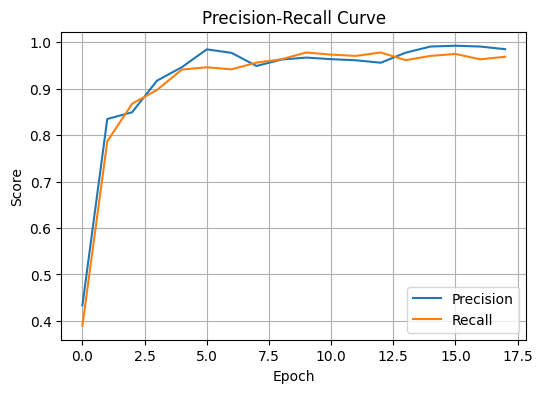

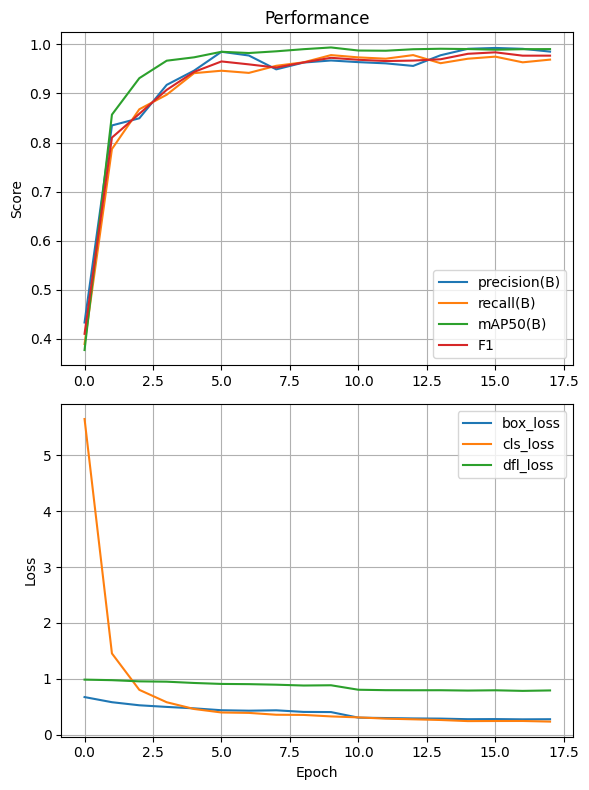

In [ ]:
plot_precision_recall(CFG)
plot_all_metrics(CFG)

In [ ]:
CFG

{'name': 'exp9_adam',
 'epochs': 20,
 'batch_size': 16,
 'optimizer': 'Adam',
 'momentum': 0.937,
 'lr0': 0.0005,
 'weight_decay': 0.0001,
 'cos_lr': True,
 'single_cls': True,
 'seed': 42,
 'amp': True,
 'patience': 20,
 'device': 'cuda',
 'confidence': 0.05,
 'iou_thres': 0.45,
 'img_size': 640,
 'augment': {'hsv_h': 0.015,
  'hsv_s': 0.7,
  'hsv_v': 0.4,
  'flipud': 0.5,
  'fliplr': 0.5,
  'translate': 0.1,
  'scale': 0.5,
  'shear': 0.01}}

In [ ]:
predict_and_save(best_model, CFG, conf=best_conf)
convert_to_csv(CFG)

🔍 Running inference & saving labels...

image 1/1 /content/drive/MyDrive/SynToReal/data/test/images/0178.jpg: 640x384 3 items, 165.6ms
Speed: 2.6ms preprocess, 165.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/SynToReal/data/test/images/0140.jpg: 640x384 1 item, 25.5ms
Speed: 2.5ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/SynToReal/data/test/images/0158.jpg: 640x384 2 items, 24.9ms
Speed: 2.4ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/SynToReal/data/test/images/0172 (2).jpg: 640x384 1 item, 25.1ms
Speed: 2.4ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/drive/MyDrive/SynToReal/data/test/images/0080.jpg: 640x384 2 items, 25.0ms
Speed: 2.3ms preprocess, 25.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 38

# 실험 적용 시각화

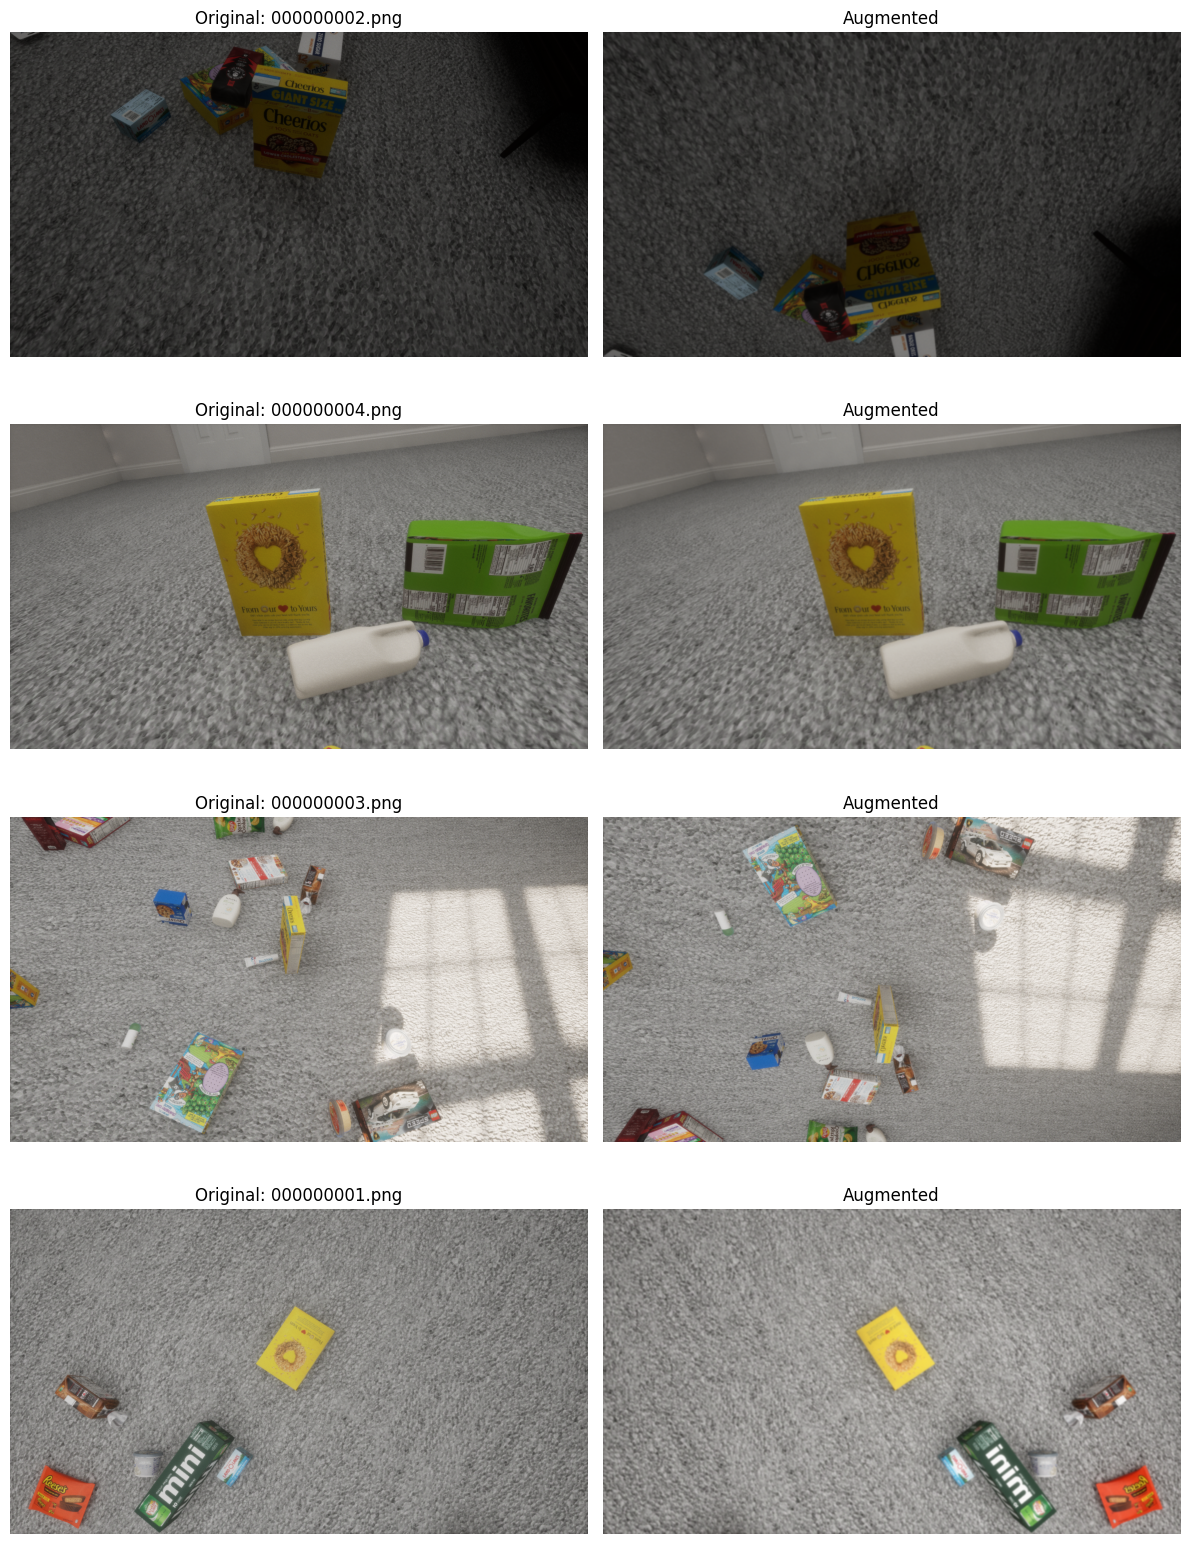

In [ ]:
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

# 1. Define the augmentation pipeline exactly as used in training
aug_pipeline = A.Compose([
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 10), p=0.5),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.2)
])

# 2. Function to display original vs augmented
def show_augmented_samples(images_dir: Path, num_samples: int = 5):
    files = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))
    samples = files[:num_samples]
    plt.figure(figsize=(12, 4 * num_samples))
    for i, img_path in enumerate(samples):
        img = np.array(Image.open(img_path))
        augmented = aug_pipeline(image=img)['image']
        # Plot original
        ax1 = plt.subplot(num_samples, 2, 2*i + 1)
        ax1.imshow(img)
        ax1.set_title(f"Original: {img_path.name}")
        ax1.axis('off')
        # Plot augmented
        ax2 = plt.subplot(num_samples, 2, 2*i + 2)
        ax2.imshow(augmented)
        ax2.set_title("Augmented")
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Run visualization on a few images from the training set
train_images_dir = Path('/content/drive/MyDrive/SynToReal/data/train/images')
show_augmented_samples(train_images_dir, num_samples=4)

# 2. 실험 설정값 정의

In [ ]:
# 실험명 자동 생성
exp_time = datetime.now().strftime('%m%d_%H%M')
EXP_NAME = f"light_aug_{exp_time}"

# 경로 및 하이퍼파라미터
IMG_SIZE = 640
EPOCHS = 100
BATCH = 16
DATA_YAML = "data.yaml"
MODEL_CFG = "yolov8n.pt"  # 또는 yolov8s.pt 등

# 3. 데이터 확인

In [ ]:
from PIL import Image
import glob

def show_sample_images(folder, num=3):
    image_paths = glob.glob(os.path.join(folder, "*.jpg"))[:num]
    for path in image_paths:
        display(Image.open(path))

In [ ]:
# 파일정보 및 설정
BASE_DIR = Path('/content/drive/MyDrive/SynToReal')
MODEL_PATH = BASE_DIR / 'yolov8s.pt'
DATA_PATH = BASE_DIR / 'yolo_params.yaml'
TEST_IMG_DIR = BASE_DIR / 'data/test/images'

PROJECT = BASE_DIR / 'runs'
SUBMIT_CSV = PROJECT / 'submission_exp6.csv'
NAME = 'exp6'

# Training config
EPOCHS = 20
BATCH_SIZE = 32
MOSAIC = 0.3
MIXUP = 0.1
OPTIMIZER = "Adam"
LR0 = 1e-4
LRF = 1e-4
SINGLE_CLS = True
SEED = 42
AMP = True # Mixed Precision
PATIENCE = 5  # 조기 종료 대기 epoch 수

# Train function
def train():
    print("\n🚀 Starting training...")
    model = YOLO(str(MODEL_PATH))
    results = model.train(
        data=str(DATA_PATH),
        epochs=EPOCHS,
        batch=BATCH_SIZE,
        device='cuda',
        single_cls=SINGLE_CLS,
        optimizer=OPTIMIZER,
        lr0=LR0,
        lrf=LRF,
        seed=SEED,
        amp=AMP,
        patience=PATIENCE,
        project=str(PROJECT),
        name=NAME,
        exist_ok=True, # True로 하면 해당 디렉토리가 기존에 존재하면 에러발생 없이 넘어가
        val=True,

        # 📌 도메인 갭 완화용 증강 설정
        mosaic=0.1,
        mixup=0.05,
        hsv_h=0.01,
        hsv_s=0.4,
        hsv_v=0.2,
        degrees=3.0,
        translate=0.03,
        scale=0.2,
        shear=2.0,
        fliplr=0.5,
    )
    print(f"✅ Training complete. Logs saved to: {results.save_dir}")
    # train 결과 로그 저장 (train dataset에 대한 val 결과)
    log_experiment(NAME, "train", results, best_conf=0.5, save_dir=Path(results.save_dir))

    return Path(results.save_dir) / "weights" / "best.pt" , Path(results.save_dir)

# metrics.json 파일이 없을 경우를  \u고려한 conf 계산함수 포기
# 대신 기본값을 그대로 반환함.
def extract_best_conf(metrics_dir):
    print("⚠️ Skipping metrics.json - using default confidence of 0.5")
    return 0.5

# 테스트 세트 평가함수
def evaluate_on_test_set(model_path, best_conf):
    print("\n📊 Evaluating predictions on test set (mAP, Precision, Recall)...")
    model = YOLO(model_path)
    metrics = model.val(data=str(DATA_PATH), split='test')

    # 출력 결과 이동
    src_path = Path("runs/detect") / metrics.save_dir.name
    dest_path = Path(PROJECT) / NAME / "val_results"
    copytree(src_path, dest_path, dirs_exist_ok=True)

    print(f"📁 Evaluation results copied to: {dest_path}")

    print(f"📌 mAP@0.5       : {metrics.box.map50:.4f}")
    print(f"📌 mAP@0.5:0.95  : {metrics.box.map:.4f}")
    print(f"📈 Precision     : {metrics.box.mp:.4f}")
    print(f"📈 Recall        : {metrics.box.mr:.4f}")

    log_experiment(NAME, "test", metrics, best_conf=best_conf, save_dir=Path(metrics.save_dir))
    return metrics

# Predict function
def predict(model_path, best_conf):
    print("\n🔍 Running inference on test images...")
    model = YOLO(model_path)
    with open(DATA_PATH, 'r') as f:
        data_yaml = yaml.safe_load(f)
    images_dir = BASE_DIR / Path(data_yaml['test'])
    if not images_dir.exists():
        sys.exit(f"Test directory {images_dir} does not exist")
    labels_output_dir = BASE_DIR / Path("predictions/labels")
    labels_output_dir.mkdir(parents=True, exist_ok=True)
    for img_path in images_dir.glob("*"):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg']:
            continue
        result = model.predict(img_path, conf=best_conf, verbose=False, augment=True)[0]
        h, w = result.orig_shape
        with open(labels_output_dir / f"{img_path.stem}.txt", "w") as f:
            for b in result.boxes:
                cls = int(b.cls); conf = b.conf.item()
                x, y, bw, bh = b.xywh[0]
                f.write(f"{cls} {conf} {x/w} {y/h} {bw/w} {bh/h}\n")
    print(f"📝 Predictions saved to {labels_output_dir}")

# Plot precision-recall curve
def plot_precision_recall():
    pr_path = Path(PROJECT) / NAME / 'results.csv'
    if not pr_path.exists():
        print("⚠️ Precision-recall data not found. Skipping plot.")
        return
    df = pd.read_csv(pr_path)
    plt.figure(figsize=(6,4))
    plt.plot(df['metrics/precision(B)'], label='Precision')
    plt.plot(df['metrics/recall(B)'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision-Recall Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_all_metrics():
    csv_path = PROJECT / NAME / 'results.csv'
    output_path = BASE_DIR / f'{NAME}_all_metrics.png'
    if not csv_path.exists():
        print("⚠️ results.csv not found. Skipping full metrics plot.")
        return
    df = pd.read_csv(csv_path)
    required_cols = {'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
                     'train/box_loss', 'train/cls_loss', 'train/dfl_loss'}
    if not required_cols.issubset(df.columns):
        print("⚠️ One or more expected columns not found. Skipping full metrics plot.")
        return

    df['F1'] = 2 * df['metrics/precision(B)'] * df['metrics/recall(B)'] / \
               (df['metrics/precision(B)'] + df['metrics/recall(B)'] + 1e-8)

    plt.figure(figsize=(6, 8))

    plt.subplot(2, 1, 1)
    plt.plot(df['metrics/precision(B)'], label='Precision')
    plt.plot(df['metrics/recall(B)'], label='Recall')
    plt.plot(df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(df['F1'], label='F1 Score')
    plt.ylabel('Metric')
    plt.title('Detection Performance Over Epochs')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df['train/box_loss'], label='Box Loss')
    plt.plot(df['train/cls_loss'], label='Class Loss')
    plt.plot(df['train/dfl_loss'], label='DFL Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"📈 All metrics plot saved to: {output_path}")

# Convert to CSV function
def convert_to_csv():
    preds_path = BASE_DIR / Path("predictions/labels")
    test_path = BASE_DIR / TEST_IMG_DIR
    test_ids = {p.stem for p in test_path.glob("*") if p.suffix.lower() in ['.jpg','.jpeg','.png']}
    predictions = []
    for txt in preds_path.glob("*.txt"):
        if txt.stem not in test_ids:
            continue
        with open(txt) as f:
            lines = [l.strip() for l in f if l.strip() and len(l.split())==6]
        pred_str = " ".join(lines) if lines else "no box"
        predictions.append({"image_id": txt.stem, "prediction_string": pred_str})
    df_test = pd.DataFrame({"image_id": sorted(test_ids)})
    df_preds = pd.DataFrame(predictions)
    df_final = df_test.merge(df_preds, on="image_id", how="left").fillna("no boxes")
    df_final.to_csv(SUBMIT_CSV, index=False, quoting=csv.QUOTE_NONNUMERIC)
    print(f"✅ CSV saved to: {SUBMIT_CSV}")

def log_experiment(name, dataset_type, metrics, best_conf, save_dir, log_path=None):
    """
    Log evaluation results to CSV for later analysis.

    Args:
        name (str): 실험 이름 (ex. exp1, exp2-1 등)
        dataset_type (str): 'train', 'val', or 'test'
        metrics: model.val() 결과 객체
        best_conf (float): best confidence threshold
        save_dir (Path): 이 실험 결과가 저장된 경로
        log_path (Path or None): CSV가 저장될 전체 로그 경로 (기본값은 BASE_DIR/experiment_logs.csv)
    """
    if log_path is None:
        log_path = BASE_DIR / "experiment_logs.csv"

    row = {
        "experiment": name,
        "dataset": dataset_type,
        "mAP@0.5": round(metrics.box.map50, 4),
        "mAP@0.5:0.95": round(metrics.box.map, 4),
        "Precision": round(metrics.box.mp, 4),
        "Recall": round(metrics.box.mr, 4),
        "best_conf": round(best_conf, 4),
        "save_dir": str(save_dir),
        "timestamp": datetime.datetime.now().isoformat(timespec='seconds')
    }

    # 파일이 존재하면 append, 없으면 헤더와 함께 생성
    df = pd.DataFrame([row])
    if log_path.exists():
        df.to_csv(log_path, mode='a', header=False, index=False)
    else:
        df.to_csv(log_path, mode='w', header=True, index=False)

    print(f"🗂️ Experiment logged to {log_path}")


## Train Model & Evaluate Test set

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'


🚀 Starting training...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/SynToReal/yolov8s.pt, data=/content/drive/MyDrive/SynToReal/yolo_params.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=/content/drive/MyDrive/SynToReal/runs, name=exp6, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

train: Scanning /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/data/train/labels.cache... 431 images, 7 backgrounds, 0 corrupt: 100%|██████████| 431/431 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.9±0.9 ms, read: 305.1±149.5 MB/s, size: 3440.9 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/data/val/labels.cache... 69 images, 1 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/SynToReal/runs/exp6/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/SynToReal/runs/exp6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.55G     0.6412      8.741     0.9291         20        640: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         69         68      0.649      0.426      0.519      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.55G     0.6069     0.7774     0.9062         16        640: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

                   all         69         68      0.861      0.822      0.861      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.55G      0.555     0.5253      0.882         17        640: 100%|██████████| 27/27 [00:32<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         69         68      0.915      0.912       0.96      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.55G     0.5215     0.4776     0.8694         17        640: 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


                   all         69         68      0.957      0.926       0.98      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.55G     0.5234      0.418     0.8625         16        640: 100%|██████████| 27/27 [00:33<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all         69         68      0.942      0.971      0.988      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.55G     0.4967     0.4031     0.8639         17        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         69         68      0.985      0.951      0.991      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.55G     0.5412     0.3809     0.8942         17        640: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         69         68      0.998      0.941      0.991       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.55G     0.4984     0.3475     0.8583         16        640: 100%|██████████| 27/27 [00:34<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         69         68          1      0.985      0.994       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.55G     0.4675     0.3235     0.8386         16        640: 100%|██████████| 27/27 [00:31<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         69         68      0.982      0.956      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.55G     0.4834     0.3535     0.8678         16        640: 100%|██████████| 27/27 [00:34<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         69         68      0.972      0.971      0.993      0.895


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.55G     0.4378     0.3137     0.8291         15        640: 100%|██████████| 27/27 [00:35<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


                   all         69         68      0.961      0.985      0.994      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.55G     0.4279     0.2908     0.8281         15        640: 100%|██████████| 27/27 [00:30<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         69         68      0.998      0.956      0.994      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.55G     0.4208     0.2687     0.8306         15        640: 100%|██████████| 27/27 [00:32<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         69         68          1      0.979      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.55G     0.4206     0.2605     0.8132         15        640: 100%|██████████| 27/27 [00:34<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         69         68      0.997      0.956      0.994      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.55G     0.4236     0.2576      0.835         15        640: 100%|██████████| 27/27 [00:34<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         69         68      0.996      0.956      0.993      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.55G     0.4104     0.2503     0.8282         15        640: 100%|██████████| 27/27 [00:30<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         69         68      0.957      0.989      0.994      0.914
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.158 hours.
Optimizer stripped from /content/drive/MyDrive/SynToReal/runs/exp6/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/SynToReal/runs/exp6/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/SynToReal/runs/exp6/weights/best.pt...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


                   all         69         68      0.961      0.985      0.994      0.919
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/drive/MyDrive/SynToReal/runs/exp6
✅ Training complete. Logs saved to: /content/drive/MyDrive/SynToReal/runs/exp6
🗂️ Experiment logged to /content/drive/MyDrive/SynToReal/experiment_logs.csv
⚠️ Skipping metrics.json - using default confidence of 0.5

🔍 Running inference on test images...
📝 Predictions saved to /content/drive/MyDrive/SynToReal/predictions/labels

📊 Evaluating predictions on test set (mAP, Precision, Recall)...
Ultralytics 8.3.115 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.5 ms, read: 152.1±167.7 MB/s, size: 698.6 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1-LWaeupfyisf-6lYqNLT_UJOinhoyP69/SynToReal/data/test/labels.cache... 164 images, 0 backgrounds, 0 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]


                   all        164        164      0.827       0.78      0.865      0.716
Speed: 2.1ms preprocess, 7.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val2
📁 Evaluation results copied to: /content/drive/MyDrive/SynToReal/runs/exp6/val_results
📌 mAP@0.5       : 0.8650
📌 mAP@0.5:0.95  : 0.7161
📈 Precision     : 0.8272
📈 Recall        : 0.7805
🗂️ Experiment logged to /content/drive/MyDrive/SynToReal/experiment_logs.csv


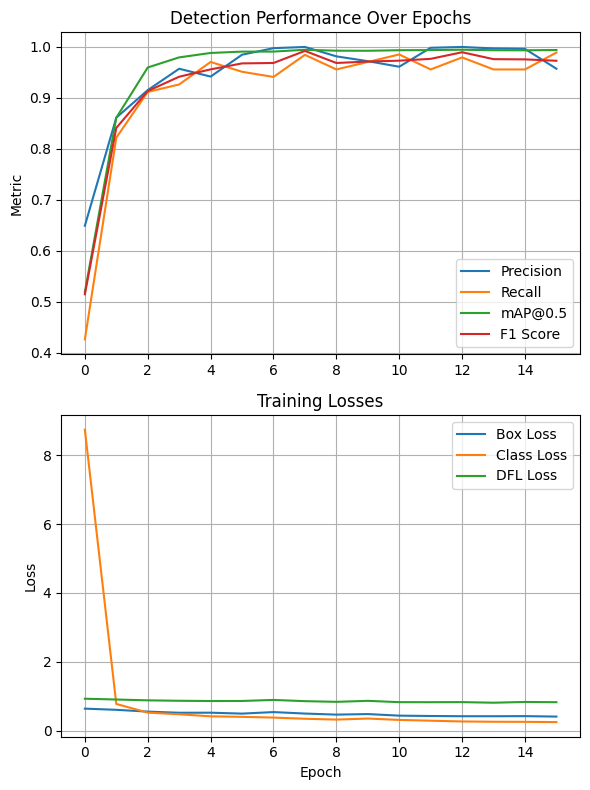

📈 All metrics plot saved to: /content/drive/MyDrive/SynToReal/exp6_all_metrics.png


In [ ]:
# 1️⃣ 학습 수행
best_model_path, metrics_dir = train()

# 2️⃣ best confidence 추출
# best_conf = extract_best_conf(metrics_dir)

# 3️⃣ test 예측 및 평가
predict(best_model_path, best_conf)
test_metrics = evaluate_on_test_set(best_model_path, best_conf)

# 4️⃣ 시각화 그래프 저장
plot_all_metrics()

In [ ]:
best_model_path

PosixPath('/content/drive/MyDrive/SynToReal/runs/exp4/weights/best.pt')

In [ ]:
convert_to_csv()

✅ CSV saved to: /content/drive/MyDrive/SynToReal/runs/submission_exp6.csv


## 증강에 대한 시각화

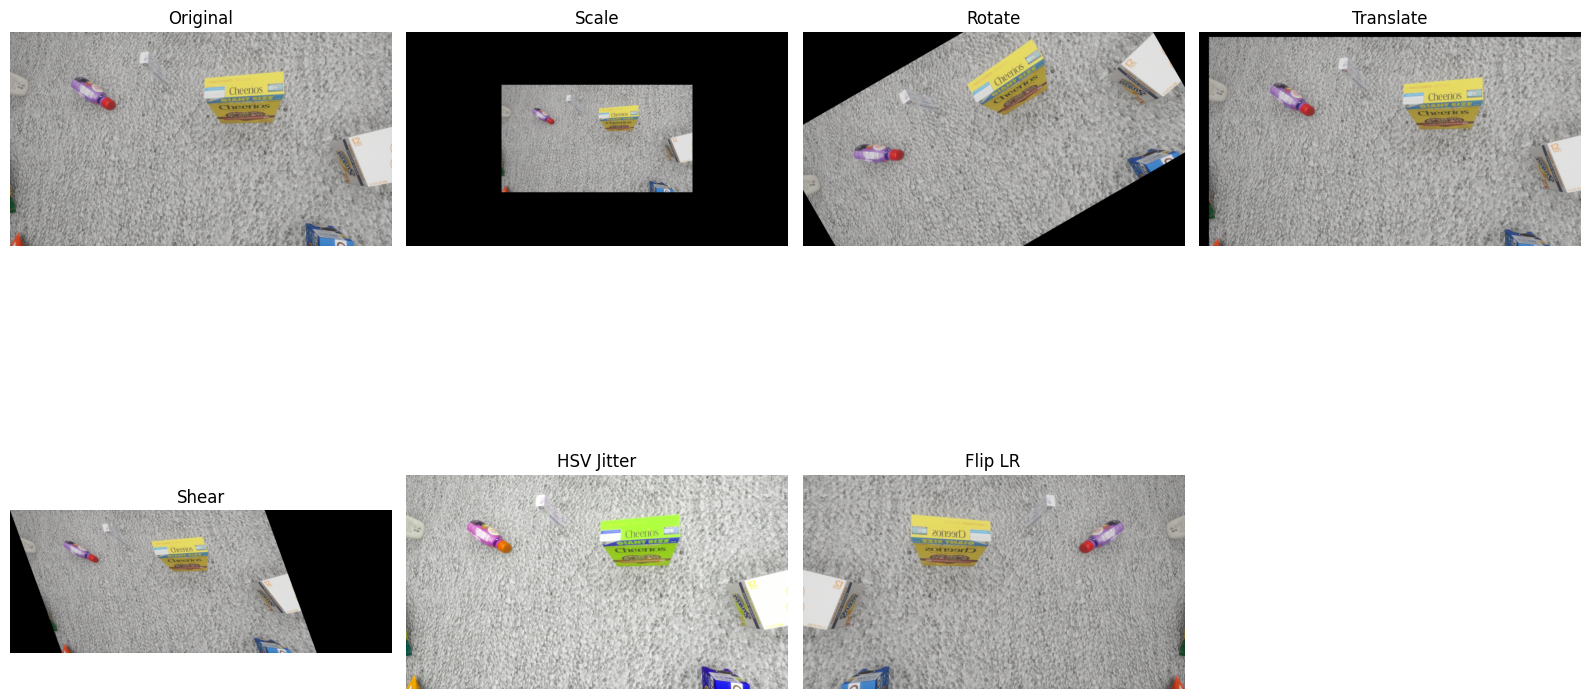

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 원본 이미지 로딩
img_path = '/content/drive/MyDrive/SynToReal/data/train/images/000000000.png'  # 실제 경로 확인
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
center = (w // 2, h // 2)

# 1. Scaling
scale = 0.5
M_scale = cv2.getRotationMatrix2D(center, 0, scale)
scaled_img = cv2.warpAffine(img, M_scale, (w, h))

# 2. Rotation
angle = 30
M_rotate = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_img = cv2.warpAffine(img, M_rotate, (w, h))

# 3. Translation
tx, ty = 50, 30
M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
translated_img = cv2.warpAffine(img, M_translate, (w, h))

# 4. Shearing
shear_deg = 20
M_shear = np.float32([[1, np.tan(np.radians(shear_deg)), 0],
                      [0, 1, 0]])
sheared_img = cv2.warpAffine(img, M_shear, (int(w * 1.5), h))

# 5. HSV (Color jittering)
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
hsv_img[..., 0] += 15  # hue shift
hsv_img[..., 1] *= 1.3  # saturation scale
hsv_img[..., 2] *= 1.2  # brightness scale
hsv_img = np.clip(hsv_img, 0, 255).astype(np.uint8)
color_jittered_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

# 6. Flipping (horizontal)
flipped_img = cv2.flip(img, 1)

# 시각화
titles = ['Original', 'Scale', 'Rotate', 'Translate', 'Shear', 'HSV Jitter', 'Flip LR']
images = [img, scaled_img, rotated_img, translated_img, sheared_img, color_jittered_img, flipped_img]

plt.figure(figsize=(16, 10))
for i, (title, im) in enumerate(zip(titles, images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


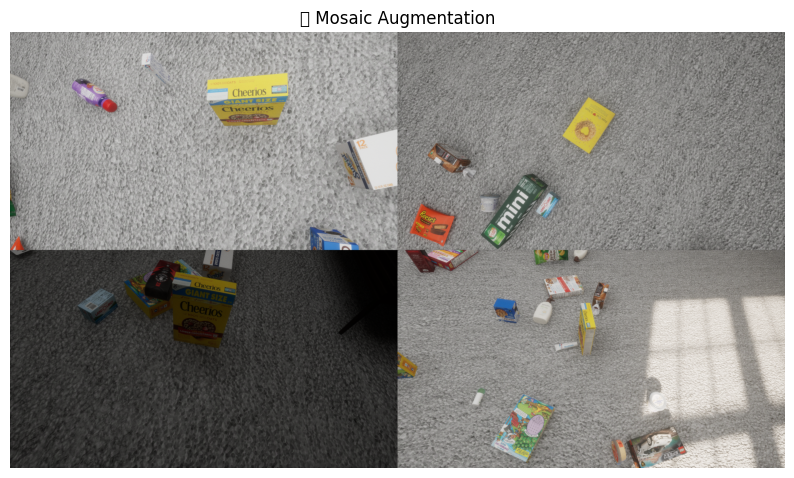

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 이미지 4장 로딩
img_dir = Path('/content/drive/MyDrive/SynToReal/data/train/images')
img_paths = sorted([p for p in img_dir.glob('*.png')])[:4]  # 상위 4개 이미지

imgs = [cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB) for p in img_paths]
h, w = imgs[0].shape[:2]

# Mosaic canvas
mosaic_img = np.full((h * 2, w * 2, 3), 114, dtype=np.uint8)

# 각 위치에 배치
mosaic_img[:h, :w] = imgs[0]     # Top-left
mosaic_img[:h, w:] = imgs[1]     # Top-right
mosaic_img[h:, :w] = imgs[2]     # Bottom-left
mosaic_img[h:, w:] = imgs[3]     # Bottom-right

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(mosaic_img)
plt.title("🧩 Mosaic Augmentation")
plt.axis('off')
plt.show()


<ipython-input-17-03237cd287bf>:25: UserWarning: Glyph 128256 (\N{TWISTED RIGHTWARDS ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128256 (\N{TWISTED RIGHTWARDS ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


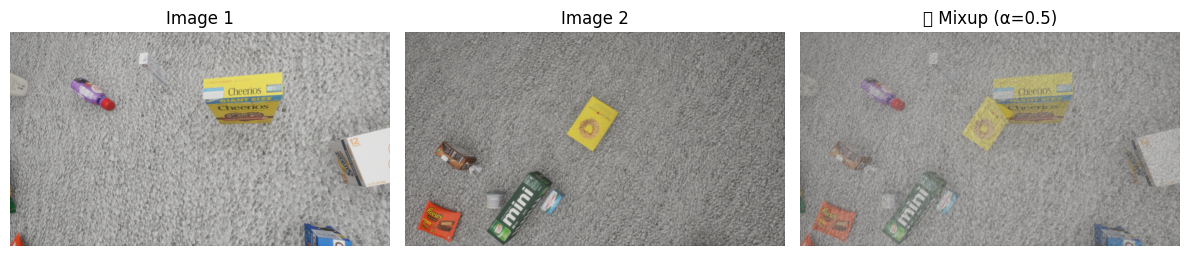

In [ ]:
# Mixup - 이미지 두 장을 가중 평균
img1 = imgs[0].astype(np.float32)
img2 = imgs[1].astype(np.float32)

alpha = 0.5  # 혼합 비율
mixup_img = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0).astype(np.uint8)

# 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img1.astype(np.uint8))
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2.astype(np.uint8))
plt.title("Image 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mixup_img)
plt.title(f"🔀 Mixup (α={alpha})")
plt.axis('off')

plt.tight_layout()
plt.show()
